# Projeto de PO-233 
Este projeto busca realizar análise do problema proposto pelo Data Science Challenge 2019 - ITA.

##### Alunos:
- Fernando Zanchitta
- Davi Xie
- Hugo Timóteo

##### Dados
Os dados podem ser adquiridos no site: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.impute import KNNImputer
import functions

In [2]:
import os
print(os.getcwd())

/Users/zanchitta/Developer/Notebooks/DSChallenge2019/src


In [3]:
train = pd.read_csv('../dataset/train.csv', index_col = 'Id')
test= pd.read_csv('../dataset/test.csv', index_col = 'Id')

In [4]:
train.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Pré-Processamento

## Remover Dados Faltantes:

In [5]:
# check missing values:
missing_values = pd.DataFrame(data={
    'Feature_name': train.columns,
    'missing_values': train.isnull().sum(),
    'percentage': train.isnull().sum() / len(train) * 100,
    'type': train.dtypes
})
missing_values.sort_values(by='percentage', ascending=False).head(20)

,Feature_name,missing_values,percentage,type
PoolQC,PoolQC,1453,99.520548,object
MiscFeature,MiscFeature,1406,96.301370,object
Alley,Alley,1369,93.767123,object
Fence,Fence,1179,80.753425,object
MasVnrType,MasVnrType,872,59.726027,object
FireplaceQu,FireplaceQu,690,47.260274,object
LotFrontage,LotFrontage,259,17.739726,float64
GarageYrBlt,GarageYrBlt,81,5.547945,float64
GarageCond,GarageCond,81,5.547945,object
GarageType,GarageType,81,5.547945,object


In [6]:
#remover colunas com mais de 50% de valores faltantes:
features_to_drop = missing_values[missing_values['percentage'] > 50]['Feature_name'].values
train = train.drop(features_to_drop, axis='columns')
test = test.drop(features_to_drop, axis='columns')


In [7]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500


## Atributos redundantes

In [8]:
# contagem de valores únicos:
unique_values = pd.DataFrame(data={"Feature_name": train.columns, "unique_values": train.nunique()})

In [9]:
unique_values.sort_values(by='unique_values', ascending=True).head(20)

,Feature_name,unique_values
Street,Street,2
Utilities,Utilities,2
CentralAir,CentralAir,2
LandSlope,LandSlope,3
BsmtHalfBath,BsmtHalfBath,3
GarageFinish,GarageFinish,3
PavedDrive,PavedDrive,3
HalfBath,HalfBath,3
BsmtCond,BsmtCond,4
BsmtExposure,BsmtExposure,4


Não temos nenhum atributo com valores únicos que possa ser descartado a priori

# Análise Exploratória

Nessa seção vamos realizar uma análise exploratória dos dados, identificando correlações, distribuições e espalhamento do nosso conjunto de dados.

Para algumas análises vamos trabalhar somente com variáveis numéricas ou categóricas, portanto vamos separar os conjuntos de dados:

In [10]:
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
category_features = train.select_dtypes(include=['object']).columns

Primeiro, vamos verificar a correlação entre atributos:

<Axes: title={'center': 'Matriz de correlação entre as variáveis numéricas.'}>

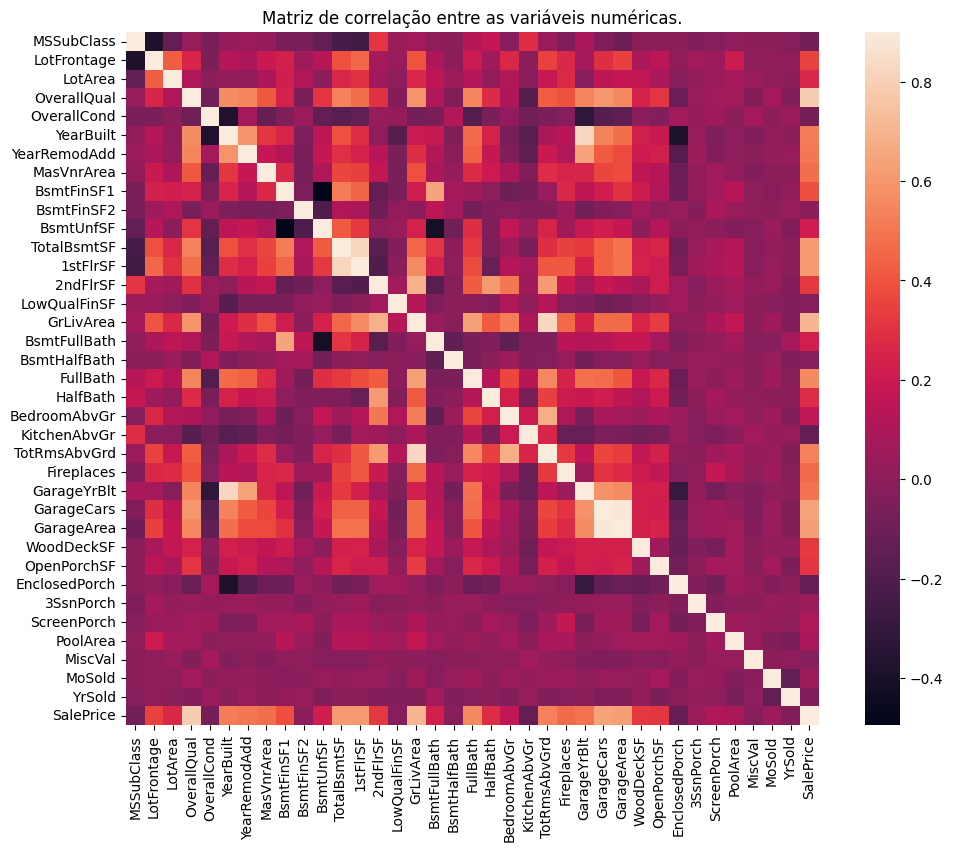

In [11]:
corr_matrix = train[numerical_features].corr()
plt.subplots(figsize=(12,9))
plt.title('Matriz de correlação entre as variáveis numéricas.')
sns.heatmap(corr_matrix, vmax=0.9, square=True)

Vamos ver quais variáveis tem correlação alta com o nosso alvo: _SalesPrice_:

In [12]:
# correlação entre as variáveis numéricas e o preço:
corr_matrix['SalePrice'].sort_values(ascending=False).head(12)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
Name: SalePrice, dtype: float64

Intuitivamente falando, é provavel que as variáveis mais correlacionadas tenham maior poder preditivo sobre o preço. Entretando devemos verificar se há correlação entre elas mesmas, para fins de simplificação, vamos pegar os atributos cuja correlação seja maior que $0.5$

<Axes: title={'center': 'Matriz de correlação entre as variáveis numéricas com correlação maior que 0.5.'}>

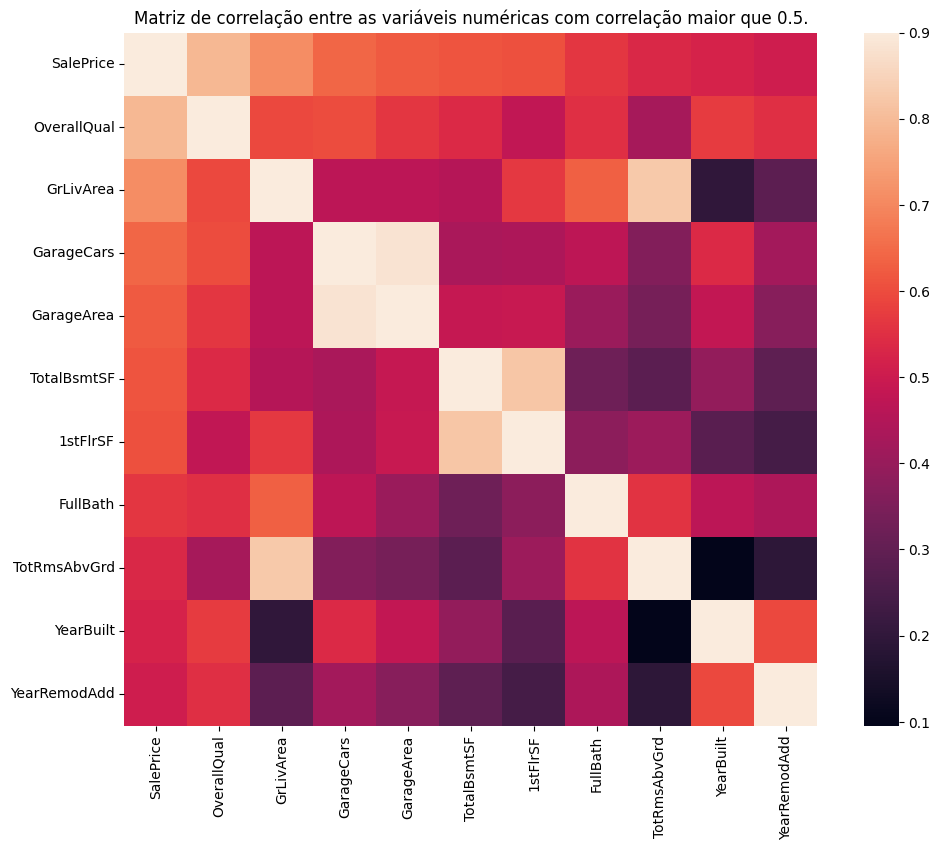

In [13]:
#atributos com correlação maior que 0.5:
features_correlated = corr_matrix['SalePrice'].sort_values(ascending=False).loc[lambda x : x > 0.5].index

#plotar a correlação entre as  variáveis com correlação maior que 0.5:
corr_matrix = train[features_correlated].corr()
plt.subplots(figsize=(12,9))
plt.title('Matriz de correlação entre as variáveis numéricas com correlação maior que 0.5.')
sns.heatmap(corr_matrix, vmax=0.9, square=True)


In [14]:

#scatterplot para colunas selecionadas:
# sns.set()

# sns.pairplot(train[features_correlated], size = 2.5)
# plt.show()

Observamos que algumas variáveis são fortemente correlacionadas: 
-  _GarageArea_ e _GarageCars_ : Faz sentido se pensar que o aumento do numero de carros na garagem exige uma garagem maior.

- _TotalBsmtSF_ e _1stFlrSF_: A relação entre o total de metragem do imovel com a metragem do primeiro andar também é pertinente.

- _TotRmsAbvGrd_ e _GrLivArea_: O número total de salas em relação ao tamanho da sala de estar também é pertinente


Portanto vamos deletar _1stFlrSF_, _GarageArea_ e _GrLivArea_ (Escolhidos de forma arbitrária).

In [15]:
# remover as variáveis com correlação maior que 0.5:
features_correlated = features_correlated.drop(['GarageArea', '1stFlrSF', 'GrLivArea'])
train = train.drop(['GarageArea', '1stFlrSF', 'GrLivArea'], axis='columns')
test = test.drop(['GarageArea', '1stFlrSF', 'GrLivArea'], axis='columns')

Para simplificação vamos escolher somente essas variáveis para nosso modelo:

### Todo:
- Aumentar a análise exploratoria e entender novas relações entre os dados
- Colocar variáveis Categóricas no modelo: verificar criterios, e metodos para isso.

as variáveis para o modelo são as seguintes:

In [16]:
features_correlated

Index(['SalePrice', 'OverallQual', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

Vamos ver a dispersão dos dados em relação a o atributo alvo para cada atributo

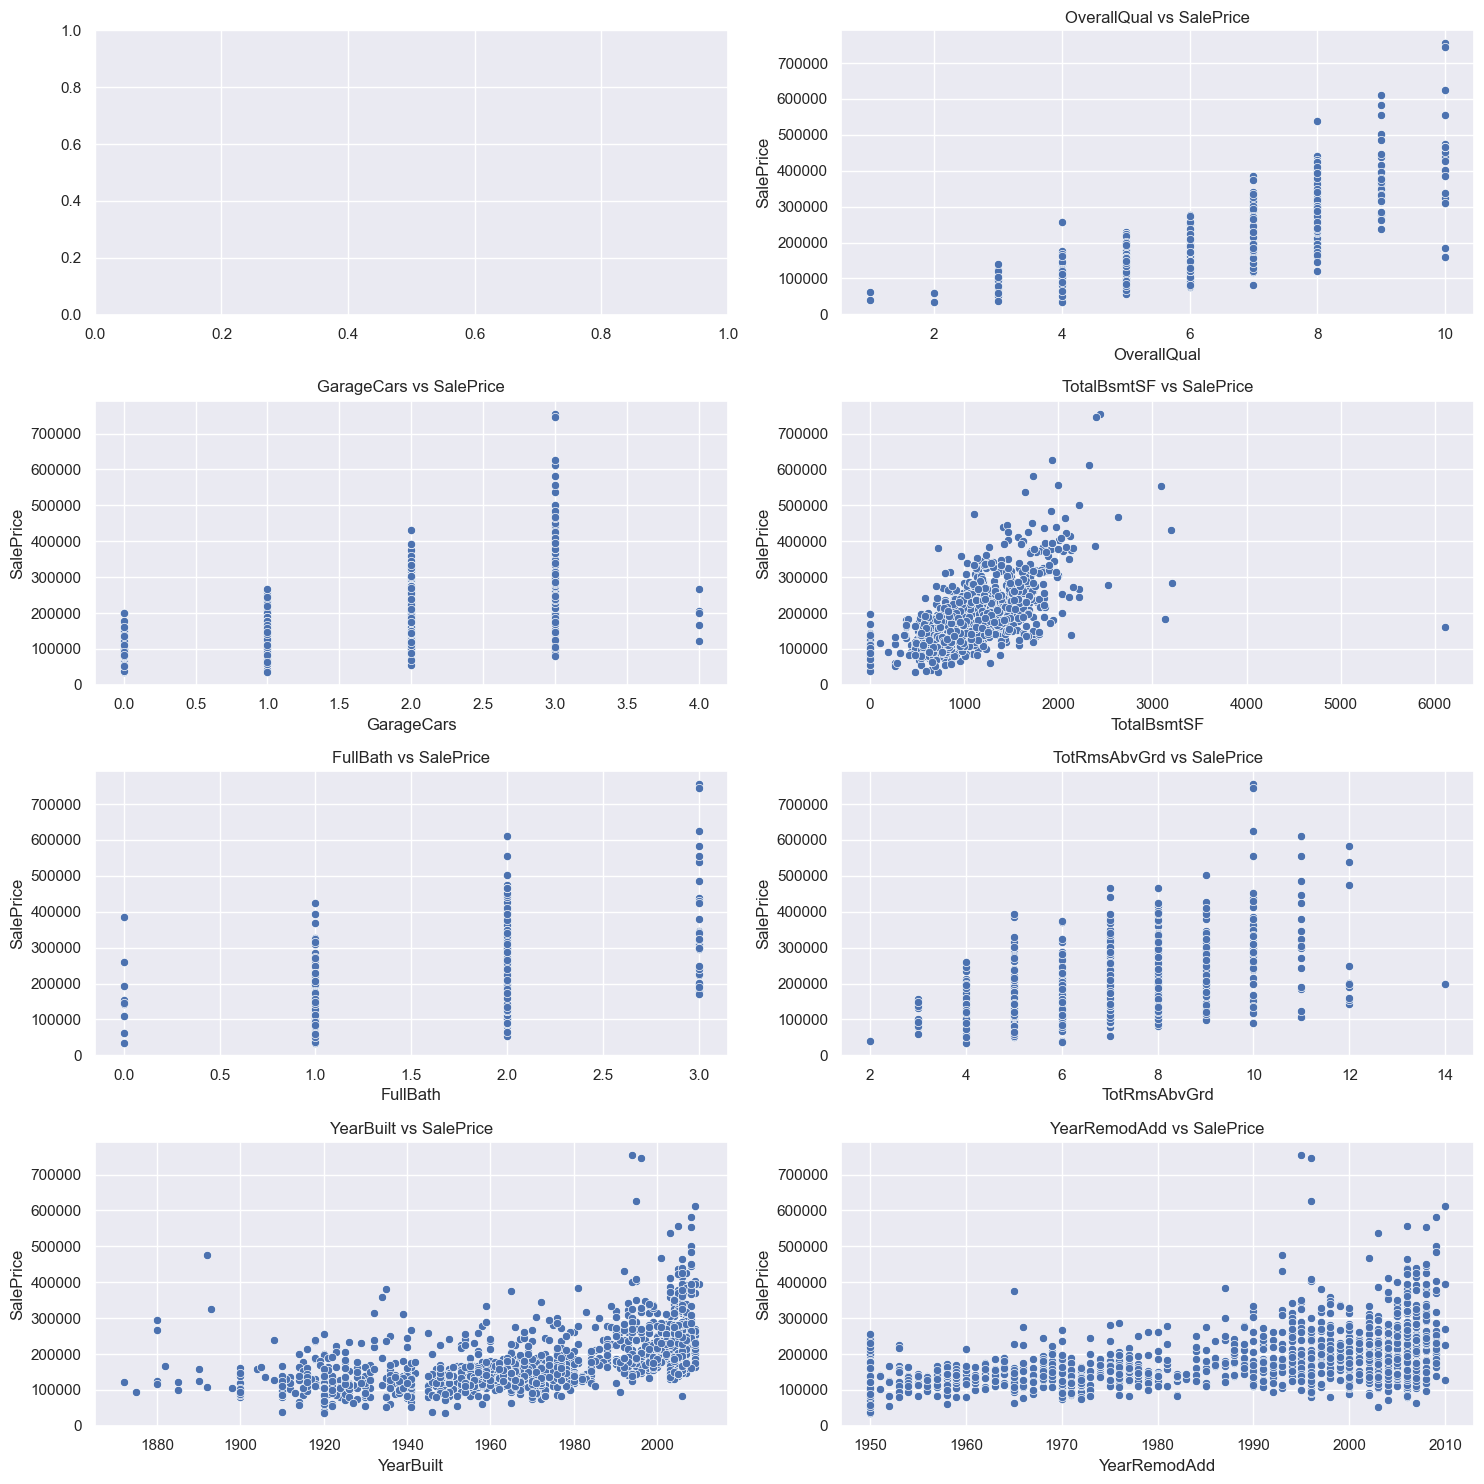

In [17]:
sns.set()


# Criar um gráfico com 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Ajustar o espaçamento entre os subplots
axes = axes.flatten()

# Iterar sobre as colunas selecionadas
for i, feature in enumerate(features_correlated):
    if feature != 'SalePrice':
        ax = axes[i]
        sns.scatterplot(x=feature, y='SalePrice', data=train, ax=ax)
        ax.set_title(f'{feature} vs SalePrice')

# remover os subplots vazios:
if len(features_correlated) < len(axes):
    for j in range(len(features_correlated), len(axes)):
        fig.delaxes(axes[j])

# ajustar o espaçamento entre os subplots:
fig.tight_layout()

# Visualizar o gráfico
plt.show()

# Engenharia de Atributos
Nessa seção vamos realizar insersão de valores, e codificação de atributos
## Valores faltantes
Vamos verificar as variáveis com valores faltantes:

In [18]:
#atributos com valores faltantes:
missing_values.loc[features_correlated]['missing_values']

SalePrice       0
OverallQual     0
GarageCars      0
TotalBsmtSF     0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
Name: missing_values, dtype: int64

Não há valores faltantes.

## Outliers
Vamos verificar se há valores outliers nos atributos e vamos realizar o tratamento deles
### Identificando Outlier com Z- Score
O z-score nos da uma idéia do quanto um determinado ponto está afastado da média dos dados, isto é , ele mede quantos desvios padrão abaixo ou acima da média populacional ou amostral os dados estão:
$$
z=\frac{x-\mu}{\sigma}
$$
Onde:
- x: observação
- $\mu$: média
- $\sigma$: desvio padrão
Assumindo uma distribuição normal, sabe-se que 99,7% dos dados estão à uma distância de três desvios padrão da média. Com base nisso, será considerado nesse trabalho que dados com distância acima de três desvios padrão serão considerados outliers.

In [19]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [20]:
# Filtrar apenas as colunas numéricas do DataFrame train após o drop
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns

# Criar uma cópia do DataFrame train
train_ZS = train[numerical_features]

# Calcular e atribuir o Z-score para cada coluna numérica, exceto a última
for col in numerical_features[:-1]:
    col_values = train_ZS[col].values
    zscore = stats.zscore(col_values)  # Calcula o Z-score para todos os valores da coluna
    outliers = (zscore > 3) | (zscore < -3)
    train_ZS.loc[outliers, col] = np.nan

# Criação do imputador KNN
imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')

# Ajuste do imputador aos dados
imputer.fit(train_ZS)

# Imputação dos valores ausentes
train_ZS = pd.DataFrame(imputer.transform(train_ZS), columns=train_ZS.columns)

caminho_arquivo_excel = '../dataset/train_ZS.xlsx'
train_ZS.to_excel(caminho_arquivo_excel, index=False)

### Identificando Outlier com Amplitude interquartil
#### Percentil
- percentil 25 : primeiro quaril
- percentil 50 : segundo quartil ou mediana
- percentil 75 : terceito quartil
#### Amplitude interquartil
É Diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1)
Para identificar Outlier rom amplitude interquartil serão realizados os procedimentos abaixo:
1. Ordenar os dados de forma crescente;
2. Calcular o valor do primeiro e terceiro quartil
3. Determinar a amplitude interquartil
4. Encontrar o limite inferior =  Q1 - 1,5*amplitude interquartil
5. Encontrar o limite superior =  Q3 + 1,5*amplitude interquartil

In [21]:
# Criar novo DataFrame com as colunas numéricas
train_IQR = train[numerical_features]

# Calcular o IQR e identificar outliers
for col in numerical_features[:-1]:
    Q1 = train_IQR[col].quantile(0.25)
    Q3 = train_IQR[col].quantile(0.75)
    IQR = Q3 - Q1
    
    limIn = Q1 - (IQR * 1.5)
    limSp = Q3 + (IQR * 1.5)
    
    # Substituir outliers por np.nan
    train_IQR.loc[(train_IQR[col] < limIn) | (train_IQR[col] > limSp), col] = np.nan

# Criar imputador KNN
imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')

# Ajustar imputador aos dados
imputer.fit(train_IQR)

# Imputar valores ausentes
train_IQR = pd.DataFrame(imputer.transform(train_IQR), columns=train_IQR.columns)

caminho_arquivo_excel = '../dataset/train_IQR.xlsx'
train_IQR.to_excel(caminho_arquivo_excel, index=False)

caminho_arquivo_excel = '../dataset/train_2.xlsx'
train[numerical_features].to_excel(caminho_arquivo_excel, index=False)

#### Imputando valores aos outliers
Em ambos os métodos acima, foram identificados os outliers e para cada um deles foi atribuido um valor ausente, ou seja, eles foram excluidos dos dados.
Para preencher os dados ausentes foi utilizada uma técnica de imputação de valores com base em proximidade, denominada KNN. O imputador KNN (K-Nearest Neighbors) é uma técnica dque pode ser utilizada para preencher valores ausentes em conjuntos de dados. Ele é um algoritmo de aprendizado de máquina capaz de prever valores ausentes com base na similaridade entre as amostras do conjunto de dados.

Inicialmente ele encontra os K vizinhos mais próximos (específicamente 15 nesse trabalho) para cada valor ausente, calculando a distância entre a amostra com valor ausente e todas as outras amostras no conjunto de dados. Ele seleciona as K amostras mais próximas com base em uma métrica de distância que, neste caso, é a distância euclidiana.

Em seguida, o KNN calcula um valor imputado para o valor ausente com base na média arimética dos valores dos vizinhos (vizinhos com pesos iguais). Por fim, o valor imputado é atribuído a cada valor ausente no conjunto de dados.

# Seleção de Atributos (opcional)
Nessa seção vamos realizar a seleção de atributos relevantes para o modelo.


# Treino e Teste

Nessa seção vamos treinar um modelo de regressão que gere uma predição dos valores de teste

In [22]:
from sklearn.model_selection import train_test_split

# regressao linear
from sklearn.linear_model import LinearRegression

#arvore de deciao
from sklearn.tree import DecisionTreeRegressor

# SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

# Adaline
from sklearn.linear_model import SGDRegressor

#MLP
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


In [23]:
new_train = train[features_correlated]

X = new_train.drop(['SalePrice'], axis=1).copy()
Y = new_train['SalePrice'] # here we need to remove unnacessary columns if exist

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=1)

In [24]:
new_train

,SalePrice,OverallQual,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,
1,208500,7,2,856,2,8,2003,2003
2,181500,6,2,1262,2,6,1976,1976
3,223500,7,2,920,2,6,2001,2002
4,140000,7,3,756,1,7,1915,1970
5,250000,8,3,1145,2,9,2000,2000
...,...,...,...,...,...,...,...,...
1456,175000,6,2,953,2,7,1999,2000
1457,210000,6,2,1542,2,7,1978,1988
1458,266500,7,1,1152,2,9,1941,2006


Separamos o dataset de treino na proporção de 70-30 em um dataset de treino e outro de teste. Perceba que o tamanho do dataset de teste realmente é 30% do dataset original.

In [25]:
print(train_X.shape, train_Y.shape)
print(test_X.shape, len(test_Y))

(1022, 7) (1022,)
(438, 7) 438


### Regressão Linear

O primeiro modelo será uma regressão linear utilizando a biblioteca do scikit-learn de linear_model importando a classe LinearRegression

In [35]:
LR = LinearRegression()
LR.fit(train_X, train_Y)

LR_predicted = LR.predict(test_X)
scoring={'R_squared':'r2','MSE':'neg_mean_squared_error'}
def CrossVal(estimator):
    scores = cross_validate(estimator, X, y, cv=10, scoring=scoring)
    r2 = scores['test_R_squared'].mean()
    mse = abs(scores['test_Square Root of MSE'].mean())
    print('R_squared:', r2)
    print('Square Root of MSE:', np.sqrt(mse))
CrossVal(LR)

NameError: name 'cross_validate' is not defined

### Árvore de Decisão

O segundo modelo será um regressor de Árvore de Decisão utilizando a biblioteca do scikit-learn de tree importando a classe DecisionTreeRegressor

In [27]:
DTR = DecisionTreeRegressor(criterion='squared_error', max_depth=15, min_samples_split=5, min_samples_leaf=5)
DTR.fit(train_X, train_Y)

DTR_predicted = DTR.predict(test_X)

### SVM

O terceiro modelo será um SVM utilizando a biblioteca do scikit-learn de svm importando a classe SVR

In [28]:
SVM = make_pipeline(RobustScaler(), RandomForestRegressor())
SVM.fit(train_X, train_Y)

SVM_predicted = SVM.predict(test_X)

### Adaline - Redes Neurais

In [29]:
ADALINE = SGDRegressor(loss='huber', learning_rate='constant', eta0=0.01, max_iter=1000)
ADALINE.fit(train_X, train_Y)

ADALINE_predicted = ADALINE.predict(test_X)

### MLP - Redes Neurais

In [30]:
MLP = MLPClassifier(hidden_layer_sizes=(40,), activation='logistic', solver='adam', max_iter=1000, early_stopping=True, validation_fraction=0.1)

MLP.fit(train_X, train_Y)
MLP_predicted = MLP.predict(test_X)

### Naive Bayes

In [31]:
NB = GaussianNB(var_smoothing=1e-9)

NB.fit(train_X, train_Y)
NB_predicted = NB.predict(test_X)
proba = NB.predict_proba(test_X)

# Avaliação do Modelo

Nessa seção vamos avaliar a performance do modelo gerado.

Os principais critério que vamos avaliar vão ser os seguintes:
- $R^2$:
O primeiro é o coeficiente de determinação, usualmente expresso por $R^2$. O coeficiente de determinação é a razão da variância do alvo, explicado ou predito pelo modelo, pela a variância total do alvo. É um valor com limites entre $0$ e $1$, e quanto mais próximo de 1 maior a capacidade do modelo em explicar ou prever a variância da variável alvo.
$$R^2 = \frac{\sum(\hat{y} - \bar{y})^2}{\sum(y - \bar{y})^2}$$

- $RMSE$:
A segunda métrica é o erro médio quadrático (_Mean Squared Error_). O $MSE$ é a média das diferenças entre o valor alvo predito e o valor real ao quadrado. Nesse sentido, é sempre maior que zero, e quanto menor o valor de $MSE$ maior a acurácia das predições do modelo. Nesse projeto, iremos utilizar a raiz quadrada de $MSE$, chamada de $RMSE$.
$$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-p_i)^2}$$


Modelo Regressão Linear:
Regressão Linear  RMSE:  40172.0293046117
Regressão Linear R2: 0.7739883057444342


<Figure size 1200x1200 with 0 Axes>

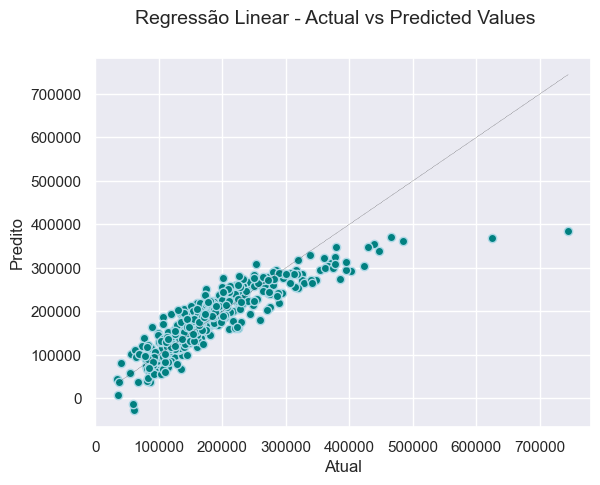

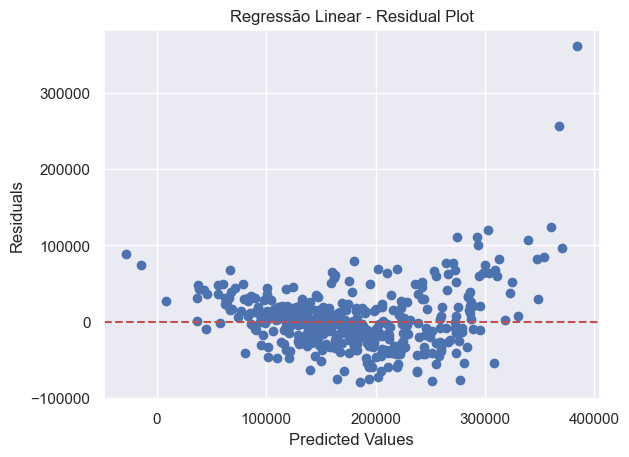


Modelo Árvore de Decisão:
Árvore de Decisão  RMSE:  37643.909164987715
Árvore de Decisão R2: 0.8015400841653715


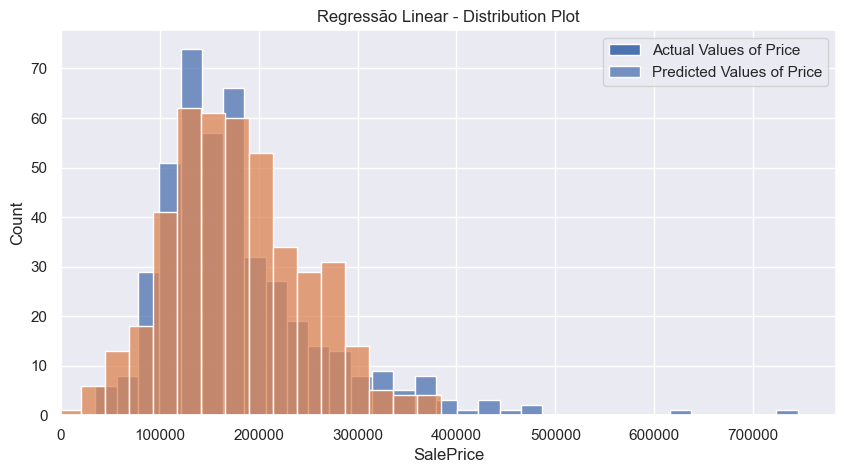

<Figure size 1200x1200 with 0 Axes>

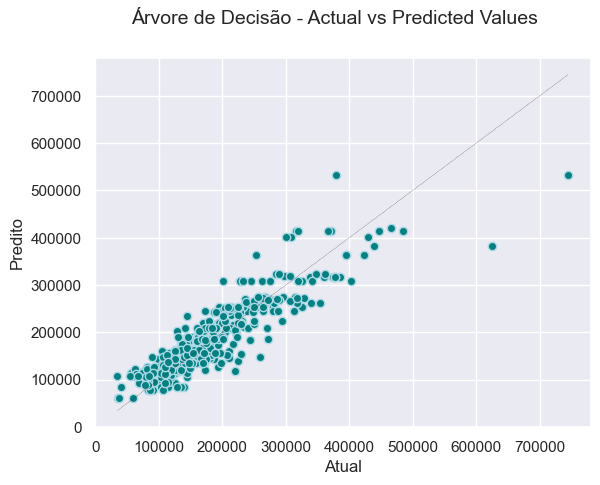

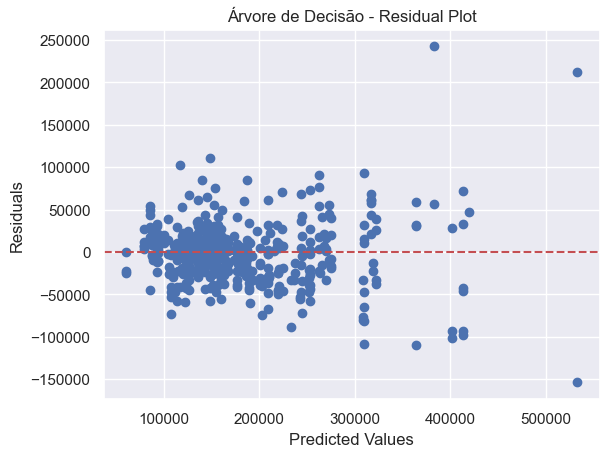


Modelo SVM:
SVM  RMSE:  30074.595391558858
SVM R2: 0.8733273209234674


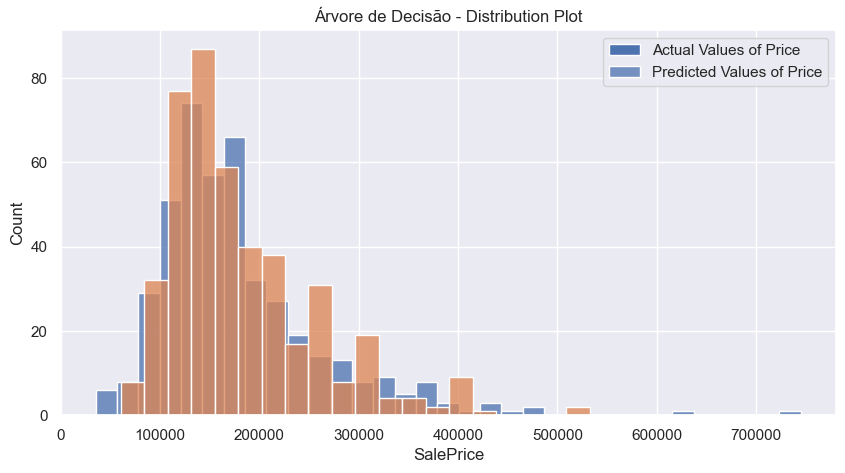

<Figure size 1200x1200 with 0 Axes>

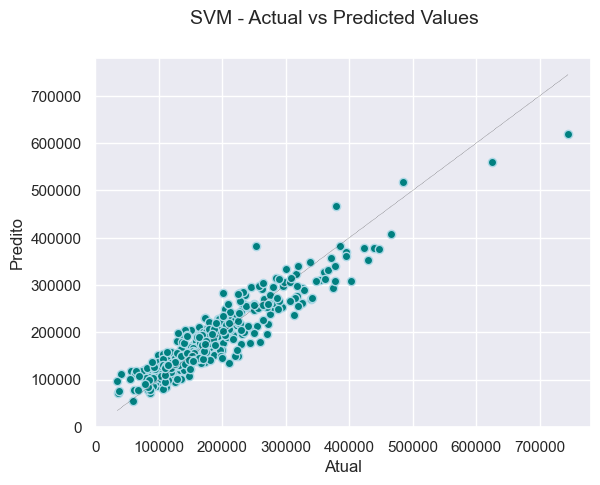

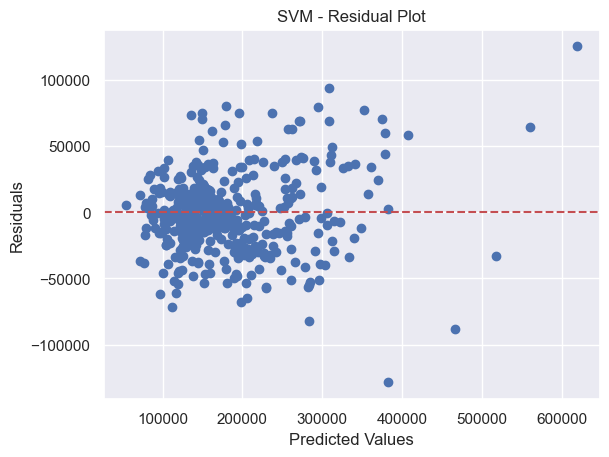


Modelo ADALINE:
ADALINE  RMSE:  65132.019414231516
ADALINE R2: 0.40588234724384553


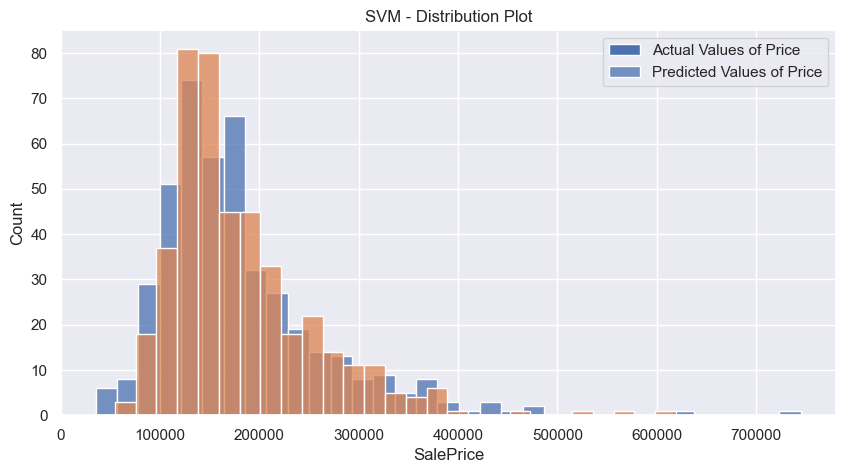

<Figure size 1200x1200 with 0 Axes>

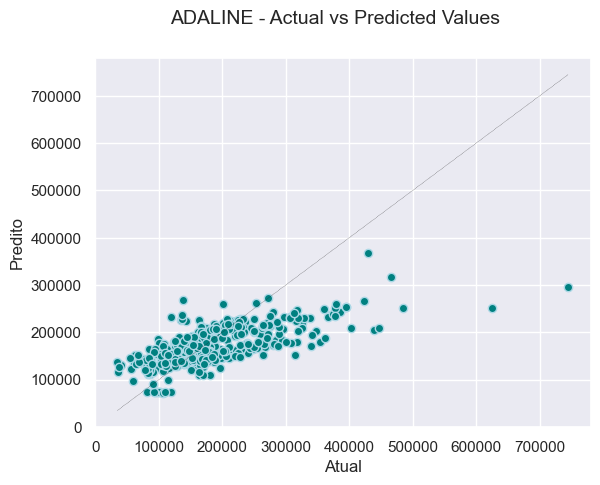

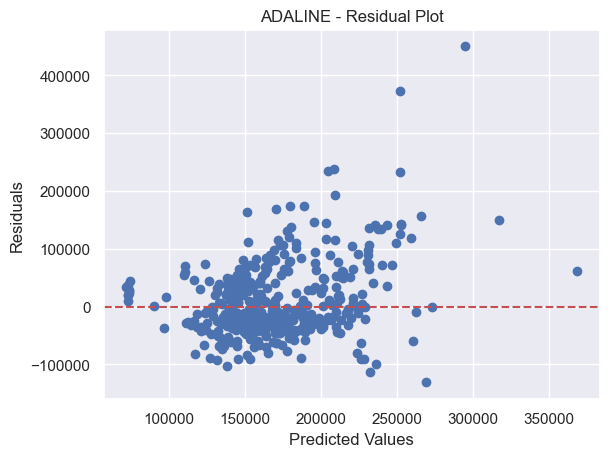


Modelo MLP:
MLP  RMSE:  117693.42069767769
MLP R2: -0.9399375095874665


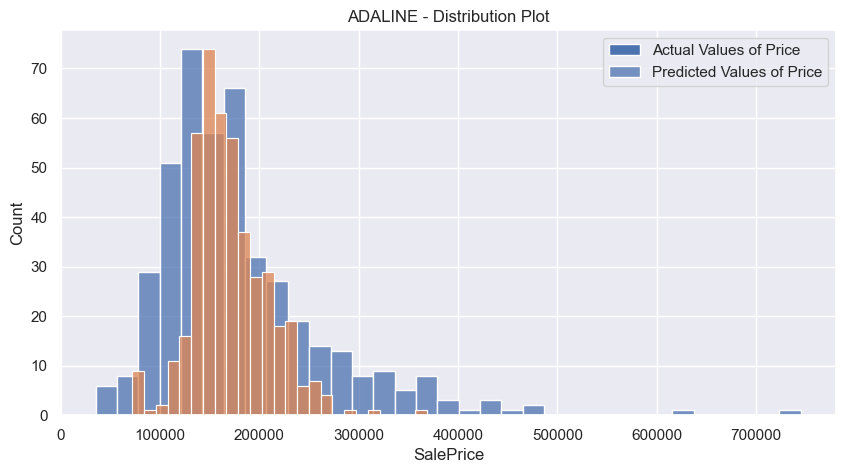

<Figure size 1200x1200 with 0 Axes>

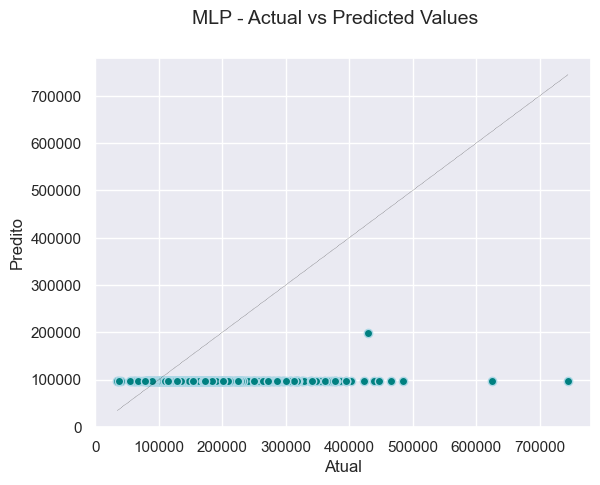

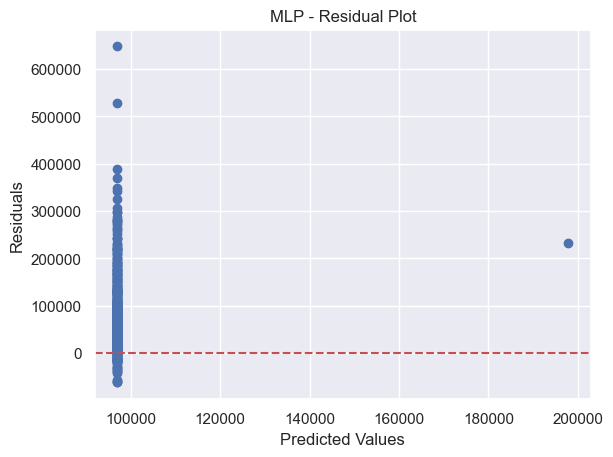


Modelo Naive Bayes:
Naive Bayes  RMSE:  48546.441365729945
Naive Bayes R2: 0.6699359918192762


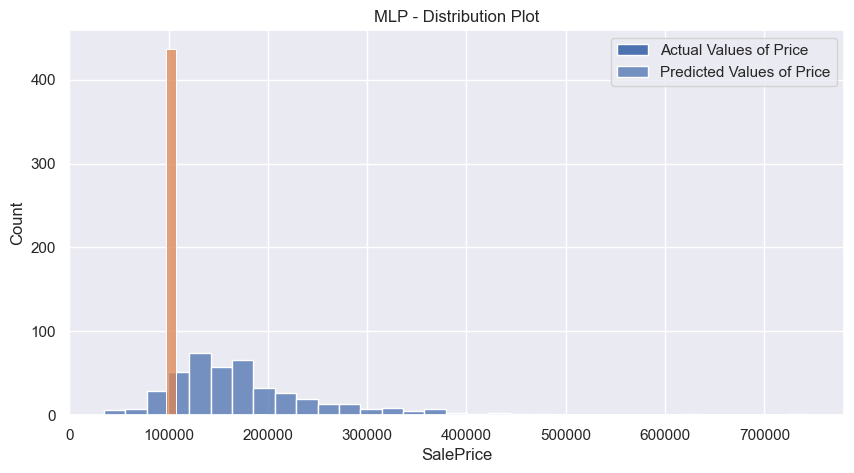

<Figure size 1200x1200 with 0 Axes>

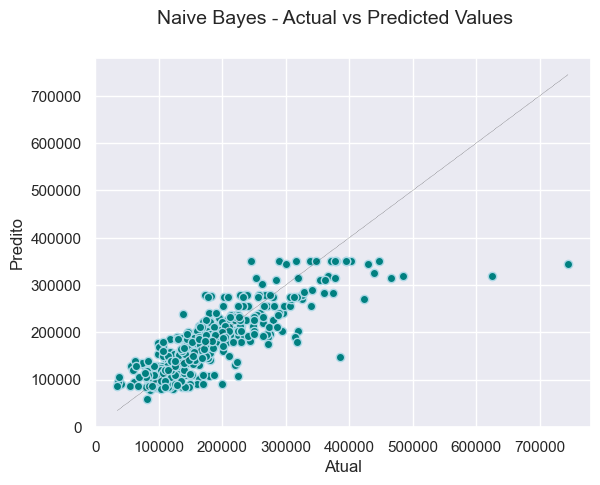

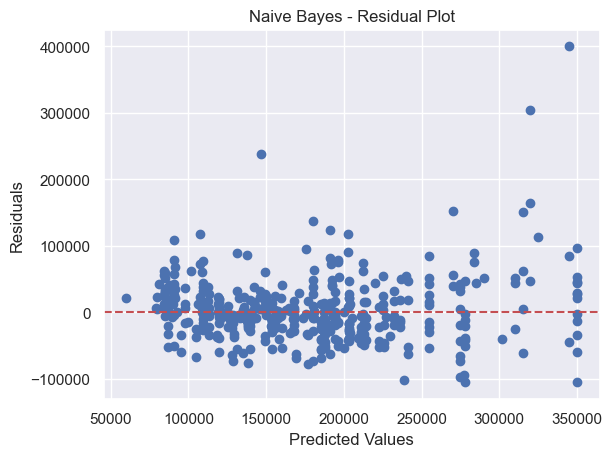

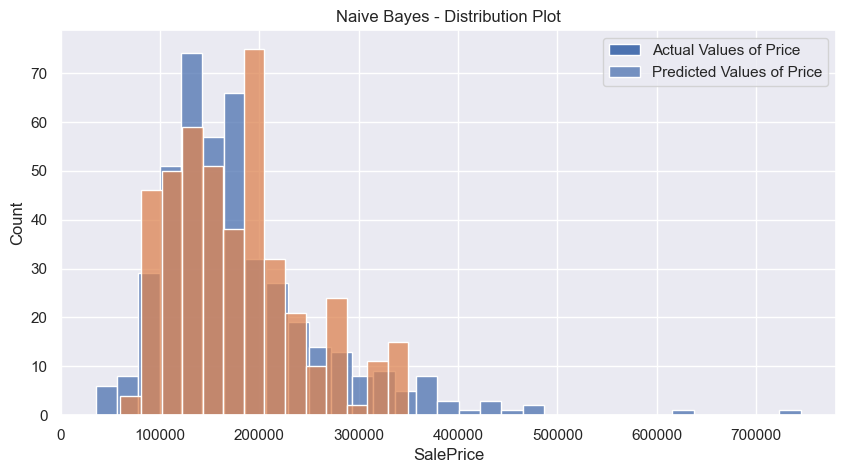

In [32]:
# avaliando
from sklearn.metrics import mean_squared_error, r2_score
from functions.actual_vs_pred_plot import actual_vs_pred_plot
from functions.model_residual_plot import model_residual_plot
from functions.regression_metrics import regression_metrics
from functions.model_dist_plot import model_dist_plot
import seaborn as sns

list_models_name = [
    "Regressão Linear",
    "Árvore de Decisão",
    "SVM",
    "ADALINE",
    "MLP",
    "Naive Bayes",
]
list_models = [LR, DTR, SVM, ADALINE, MLP, NB]
list_models_predicted = [LR_predicted, DTR_predicted, SVM_predicted, ADALINE_predicted, MLP_predicted, NB_predicted]
list_models_RMSE = []
list_models_R2 = []

for i in range(0, len(list_models)):
    model_predicted = list_models_predicted[i]
    model_name = list_models_name[i]
    print("\nModelo " + model_name + ":")

    rmse, r2 = regression_metrics(model_predicted, test_Y,model_name)
    list_models_RMSE.append(rmse)
    list_models_R2.append(r2)

    actual_vs_pred_plot(test_Y, model_predicted,model_name)

    # Create residual plot
    model_residual_plot(test_Y, model_predicted, model_name)
    model_dist_plot(test_Y, model_predicted, model_name)


Comparando os $RMSE$ de cada modelo gerado.

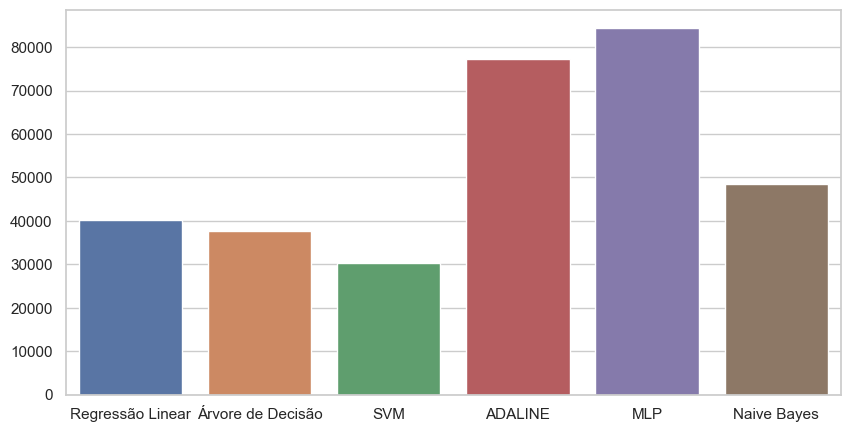

In [39]:
# comparando os modelos por RMSE:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list_models_name, y=list_models_RMSE)

Portanto, seguindo a métrica de _Root Mean Squared Error_ como a principal para fazer seleção dos modelos, o melhor modelo foi:

In [33]:
model_index = np.argmin(list_models_RMSE)
model_name = list_models_name[model_index]
model_predicted = list_models_predicted[model_index]
print("\nModelo com melhor R2: " + model_name)
print("RMSE: " + str(list_models_RMSE[model_index]))
print("R2: " + str(list_models_R2[model_index]))



Modelo com melhor R2: SVM
RMSE: 30074.595391558858
R2: 0.8733273209234674


In [34]:
from sklearn.impute import SimpleImputer

melhor_modelo = SVM

validate_columns = features_correlated.drop(['SalePrice'])
validate_df = test[validate_columns]

# Eliminate these lines after - Preprocess the data to handle missing values
imputer = SimpleImputer(strategy='mean')
validate_df = pd.DataFrame(imputer.fit_transform(validate_df), columns=validate_columns)

validate = validate_df.copy()
validate['SalePrice'] = melhor_modelo.predict(validate_df)

validate

predicted_sale_price = validate
predicted_sale_price.to_csv("SalePrice_predicted.csv", index=False)
predicted_sale_price.head()

,OverallQual,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
0,5.0,1.0,882.0,1.0,5.0,1961.0,1961.0,111703.493333
1,6.0,1.0,1329.0,1.0,6.0,1958.0,1958.0,145212.333333
2,5.0,2.0,928.0,2.0,6.0,1997.0,1998.0,169701.600000
3,6.0,2.0,926.0,2.0,7.0,1998.0,1998.0,194384.000000
4,8.0,2.0,1280.0,2.0,5.0,1992.0,1992.0,204112.060000


# Considerações finais